#**Telecom Customer Churn** - Exploratory data analysis and prediction 

**About the data** (source: Kaggle)

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The dataset includes information about:

*   Customers who left within the last month – the column is called Churn
*   Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
*   Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
*   Demographic info about customers – gender, age range, and if they have partners and dependents


**Mission**

Through exploratory data analysis better understand the data and try to predict customer churn using different classification algorithms.

##Importing the libraries

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

##Importing the data

In [64]:
dataset = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [65]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [66]:
dataset.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [67]:
dataset.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

We should convert object type of the column TotalCharges because it is numerical.

In [68]:
dataset.TotalCharges = pd.to_numeric(dataset.TotalCharges, errors="coerce") # coerce replaces all non-numeric values with NaN

In [69]:
dataset.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Missing 11 values in the column TotalCharges so I will remove those customers from the dataset.

In [70]:
dataset = dataset.dropna(axis = 0) # Drop rows which contain missing values

##Exploratory Data Analysis

In [71]:
dataset.shape

(7032, 21)

In [72]:
#u = np.unique(dataset.customerID)
#len(u)

Dataset contains 7032 customers.

In [73]:
dataset.gender.value_counts()

Male      3549
Female    3483
Name: gender, dtype: int64

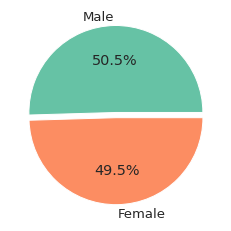

In [74]:
plt.pie([dataset.gender.value_counts()[0], dataset.gender.value_counts()[1]], labels = ['Male', 'Female'], autopct="%.1f%%", explode=[0.03]*2, 
        colors = sn.color_palette('Set2'))
plt.show()

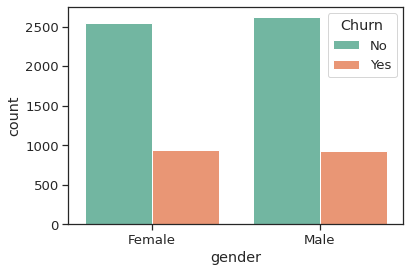

In [75]:
sn.countplot(x='gender', hue='Churn', data=dataset, palette='Set2')
plt.show()

Dataset is balanced regarding gender feature and churn is pretty much the same for men and women. 

In [76]:
dataset.SeniorCitizen.value_counts()

0    5890
1    1142
Name: SeniorCitizen, dtype: int64

Less senior citizens among customers.

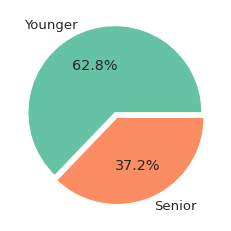

In [77]:
plt.pie([dataset.SeniorCitizen.value_counts()[0], dataset.gender.value_counts()[1]], labels = ['Younger', 'Senior'], autopct="%.1f%%", explode=[0.03]*2, 
        colors = sn.color_palette('Set2'))
plt.show()

In [78]:
contingency_table = pd.crosstab(dataset.SeniorCitizen, dataset.Churn)
contingency_table

Churn,No,Yes
SeniorCitizen,,
0,4497,1393
1,666,476


In [79]:
contingency_table = pd.crosstab(dataset.Partner, dataset.Churn)
contingency_table

Churn,No,Yes
Partner,,
No,2439,1200
Yes,2724,669


In [80]:
dataset.Dependents.value_counts()

No     4933
Yes    2099
Name: Dependents, dtype: int64

In [81]:
contingency_table = pd.crosstab(dataset.Dependents, dataset.Churn)
contingency_table

Churn,No,Yes
Dependents,,
No,3390,1543
Yes,1773,326


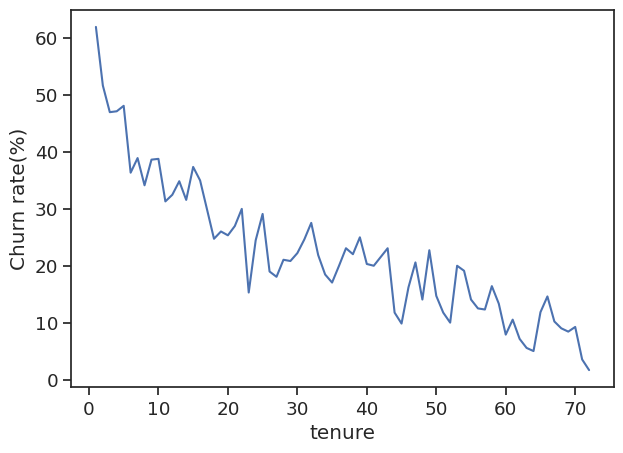

In [82]:
no_churn = dataset.groupby(['Churn','tenure']).count().transpose()['No']
yes_churn = dataset.groupby(['Churn','tenure']).count().transpose()['Yes']

churn_rates_Yes = 100 * yes_churn/(no_churn+yes_churn)
plt.figure(figsize=(7,5),dpi=100)
plt.ylabel('Churn rate(%)')
churn_rates_Yes.iloc[0].plot()

It is clear that customer churn rate decreases as the tenure grows.<br>
Let us group tenure and see what we get.

In [83]:
def yearly_tenure(tenure):
    if tenure <= 12:
        return 1
    elif tenure >12 and tenure <=24:
        return 2
    elif tenure >24 and tenure <=36:
        return 3
    elif tenure >36 and tenure <=48:
        return 4
    elif tenure >48 and tenure <=60:
        return 5
    elif tenure > 60 and tenure <=72:
        return 6

In [84]:
dataset['yearly_tenure'] = dataset['tenure'].apply(yearly_tenure)

Text(0.5, 0, 'Tenure in years')

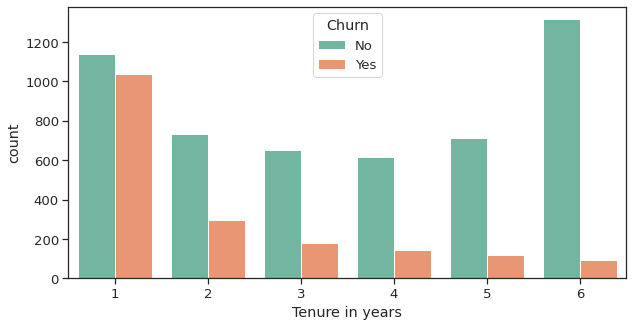

In [85]:
plt.figure(figsize=(10,5))
sn.countplot(data=dataset,x='yearly_tenure',hue='Churn', palette='Set2')
plt.xlabel('Tenure in years')

Looking at the graph above it is obvious that the churn rate declines with longer tenure. 

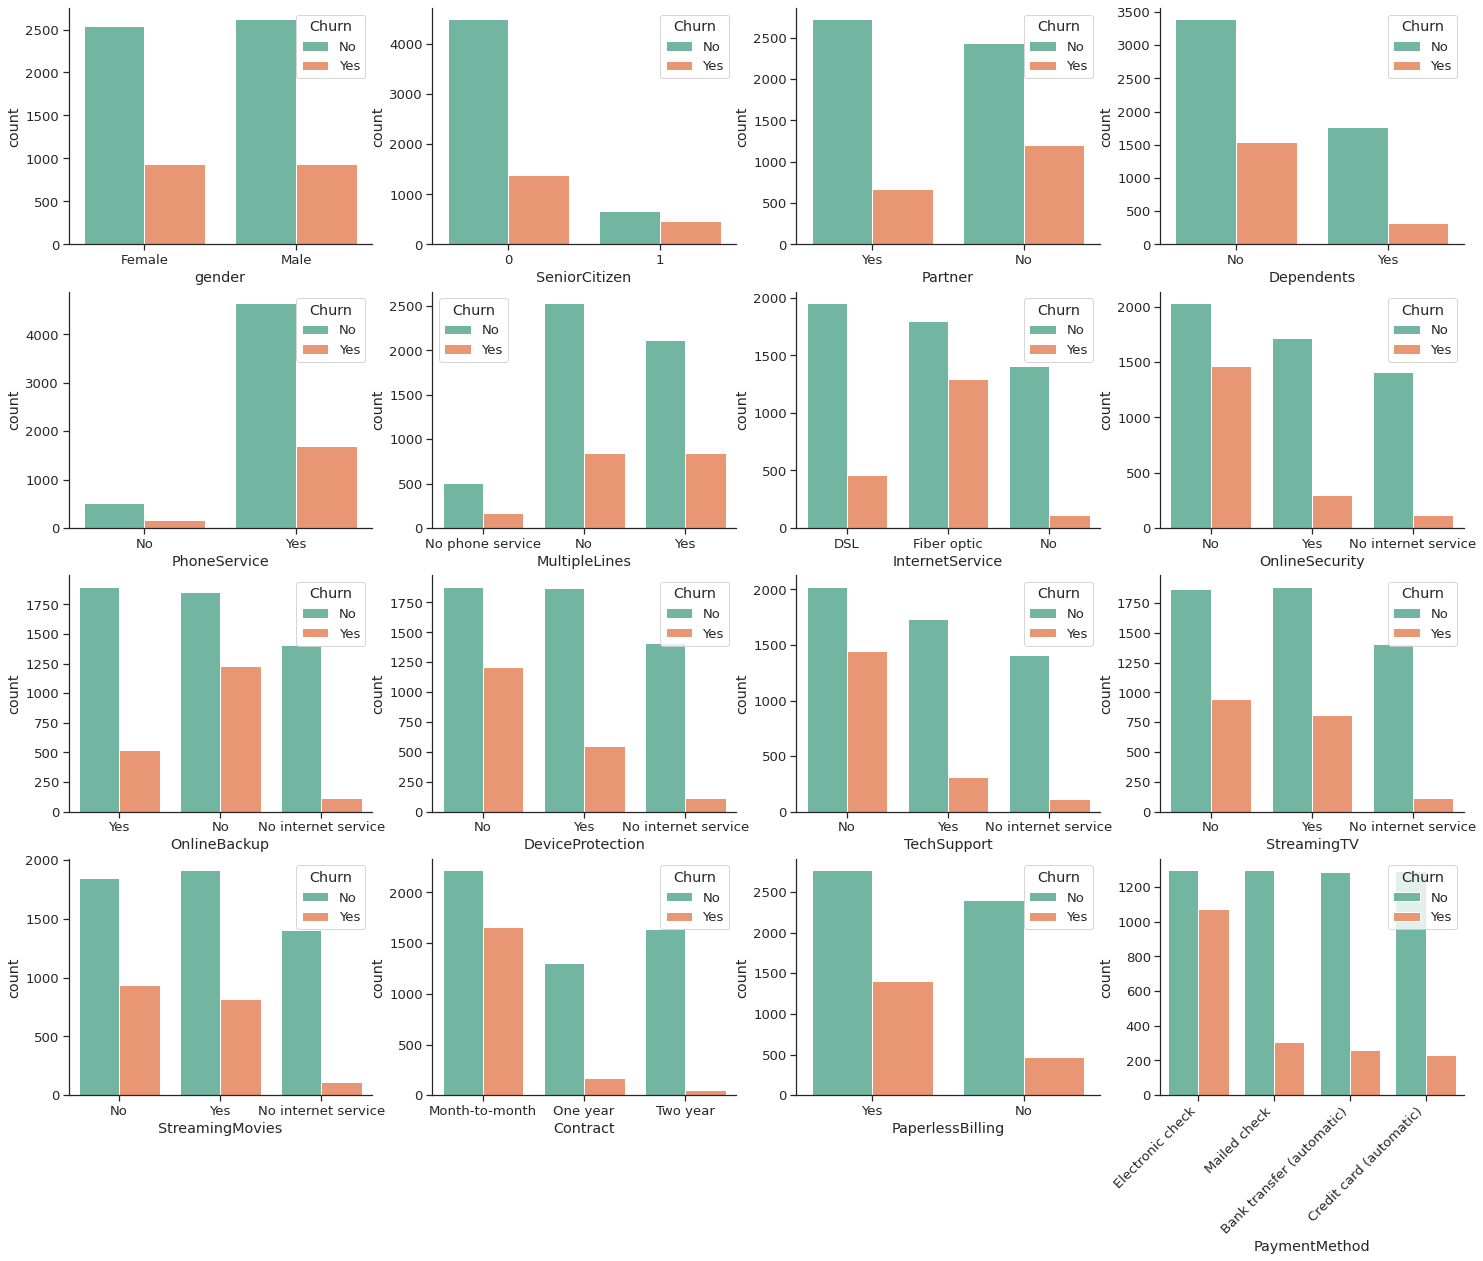

In [86]:
to_drop = ['customerID', 'tenure', 'yearly_tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
columns_to_visualize = dataset.drop(to_drop, axis = 1)

plt.figure(figsize = (25, 20))
sn.set(font_scale = 1.2)
sn.set_style('ticks')

for i, column in enumerate(columns_to_visualize):
    plt.subplot(4, 4, i+1)
    sn.countplot(data = dataset, x = column, hue = 'Churn', palette = 'Set2')
    
sn.despine()

plt.xticks(rotation=45, horizontalalignment='right');

In [87]:
contingency_table = pd.crosstab(dataset.Contract, dataset.Churn)
contingency_table

Churn,No,Yes
Contract,,
Month-to-month,2220,1655
One year,1306,166
Two year,1637,48


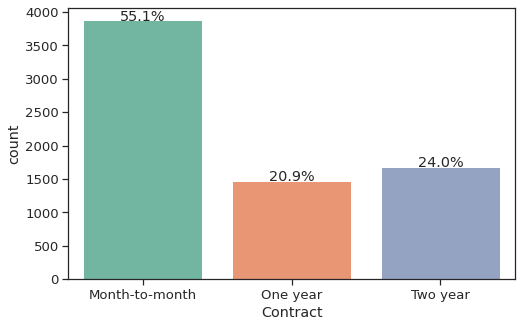

In [88]:
plt.figure(figsize=(8,5))
ax = sn.countplot(x='Contract', data=dataset, palette='Set2')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(dataset.Contract))
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

Month-to-month contracts are the most popular type of contract among customers. Also, customers with month-to-month contract tend to churn more.

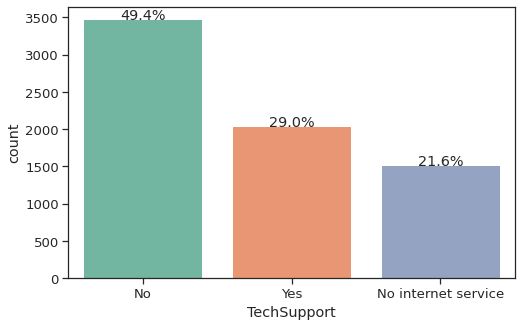

In [89]:
plt.figure(figsize=(8,5))
ax = sn.countplot(x='TechSupport', data=dataset, palette='Set2')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(dataset.Contract))
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

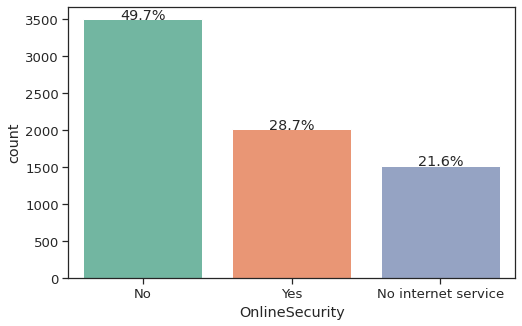

In [90]:
plt.figure(figsize=(8,5))
ax = sn.countplot(x='OnlineSecurity', data=dataset, palette='Set2')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(dataset.Contract))
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

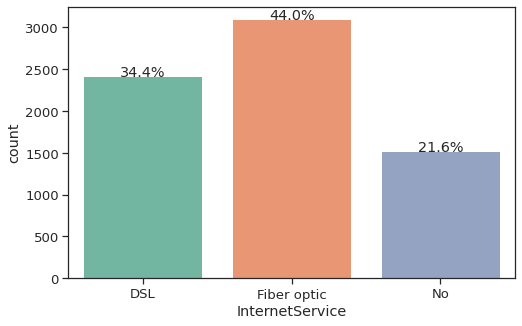

In [91]:
plt.figure(figsize=(8,5))
ax = sn.countplot(x='InternetService', data=dataset, palette='Set2')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(dataset.Contract))
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

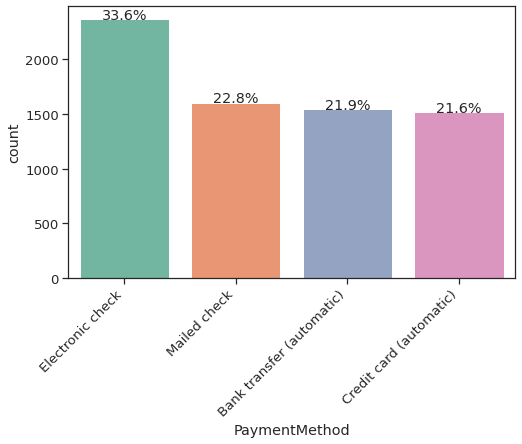

In [92]:
plt.figure(figsize=(8,5))
ax = sn.countplot(x='PaymentMethod', data=dataset, palette='Set2')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(dataset.Contract))
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.xticks(rotation=45, horizontalalignment='right');
plt.show()


In [93]:
contingency_table = pd.crosstab(dataset.InternetService, dataset.Churn)
contingency_table

Churn,No,Yes
InternetService,,
DSL,1957,459
Fiber optic,1799,1297
No,1407,113


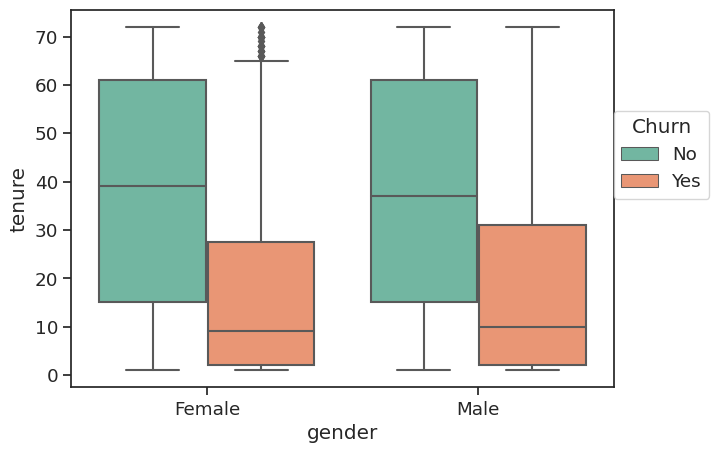

In [94]:
plt.figure(figsize=(7,5),dpi=100)
sn.boxplot(data=dataset,x='gender',y='tenure',hue='Churn',palette='Set2')
plt.legend(loc=(1,0.5),title = "Churn")

The boxplot shows few tenure outliers for female customers who churn but they are "small" so there is no need for further exploration.<br>
It also shows that regardless of gender, people who have a lower tenure period tend to churn more with identical representations for both genders.

In [95]:
dataset['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

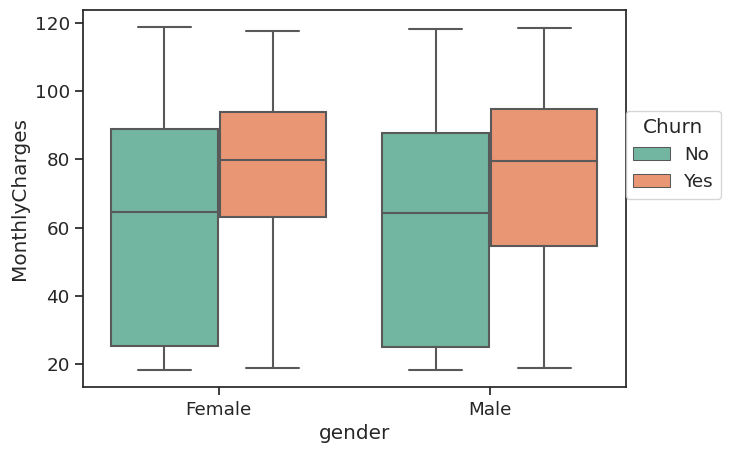

In [96]:
plt.figure(figsize=(7,5),dpi=100)
sn.boxplot(data=dataset,x='gender', y= 'MonthlyCharges',hue='Churn',palette='Set2')
plt.legend(loc=(1,0.5),title = "Churn")

We can see that the monthly charges are almost identical for men and women who churn and for men and women do don't. Also, it is shown that the median of monthly charges for customers who churn (both men and women) is greater that the median of those who don't.

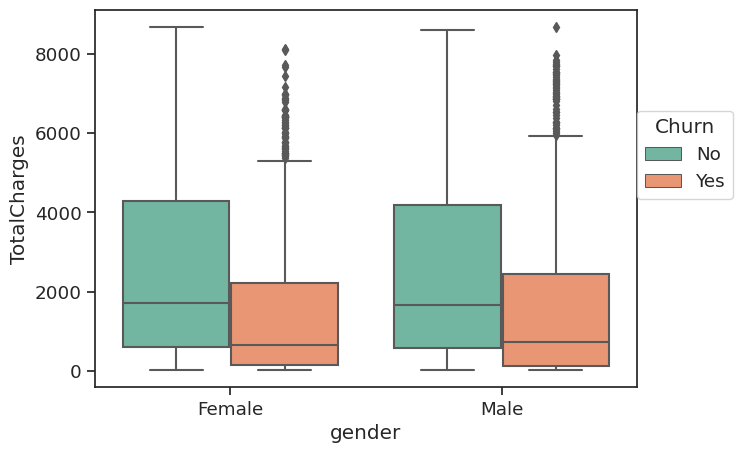

In [97]:
plt.figure(figsize=(7,5),dpi=100)
sn.boxplot(data=dataset,x='gender',y='TotalCharges',hue='Churn',palette='Set2')
plt.legend(loc=(1,0.5),title = "Churn")

Again, almost identical situation with total charges considering churning and gender.

In [98]:
df_corr  = pd.get_dummies(dataset[['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','Churn']]).corr()

In [99]:
df_corr.head()

,SeniorCitizen,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
SeniorCitizen,1.000000,0.001819,-0.001819,-0.016957,0.016957,0.210550,-0.210550,-0.008392,0.008392,-0.136377,...,-0.046491,-0.116205,-0.156258,0.156258,-0.016235,-0.024359,0.171322,-0.152987,-0.150541,0.150541
gender_Female,0.001819,1.000000,-1.000000,-0.001379,0.001379,0.010349,-0.010349,-0.007515,0.007515,-0.004335,...,-0.007755,0.003603,-0.011902,0.011902,0.015973,-0.001632,-0.000844,-0.013199,-0.008545,0.008545
gender_Male,-0.001819,-1.000000,1.000000,0.001379,-0.001379,-0.010349,0.010349,0.007515,-0.007515,0.004335,...,0.007755,-0.003603,0.011902,-0.011902,-0.015973,0.001632,0.000844,0.013199,0.008545,-0.008545
Partner_No,-0.016957,-0.001379,0.001379,1.000000,-1.000000,0.452269,-0.452269,0.018397,-0.018397,0.130028,...,-0.083067,-0.247334,-0.013957,0.013957,-0.111406,-0.082327,0.083207,0.096948,-0.149982,0.149982
Partner_Yes,0.016957,0.001379,-0.001379,-1.000000,1.000000,-0.452269,0.452269,-0.018397,0.018397,-0.130028,...,0.083067,0.247334,0.013957,-0.013957,0.111406,0.082327,-0.083207,-0.096948,0.149982,-0.149982


In [100]:
df_corr['Churn_Yes'].sort_values().iloc[1:-1]

Contract_Two year                         -0.301552
StreamingMovies_No internet service       -0.227578
StreamingTV_No internet service           -0.227578
TechSupport_No internet service           -0.227578
DeviceProtection_No internet service      -0.227578
OnlineBackup_No internet service          -0.227578
OnlineSecurity_No internet service        -0.227578
InternetService_No                        -0.227578
PaperlessBilling_No                       -0.191454
Contract_One year                         -0.178225
OnlineSecurity_Yes                        -0.171270
TechSupport_Yes                           -0.164716
Dependents_Yes                            -0.163128
Partner_Yes                               -0.149982
PaymentMethod_Credit card (automatic)     -0.134687
InternetService_DSL                       -0.124141
PaymentMethod_Bank transfer (automatic)   -0.118136
PaymentMethod_Mailed check                -0.090773
OnlineBackup_Yes                          -0.082307
DeviceProtec

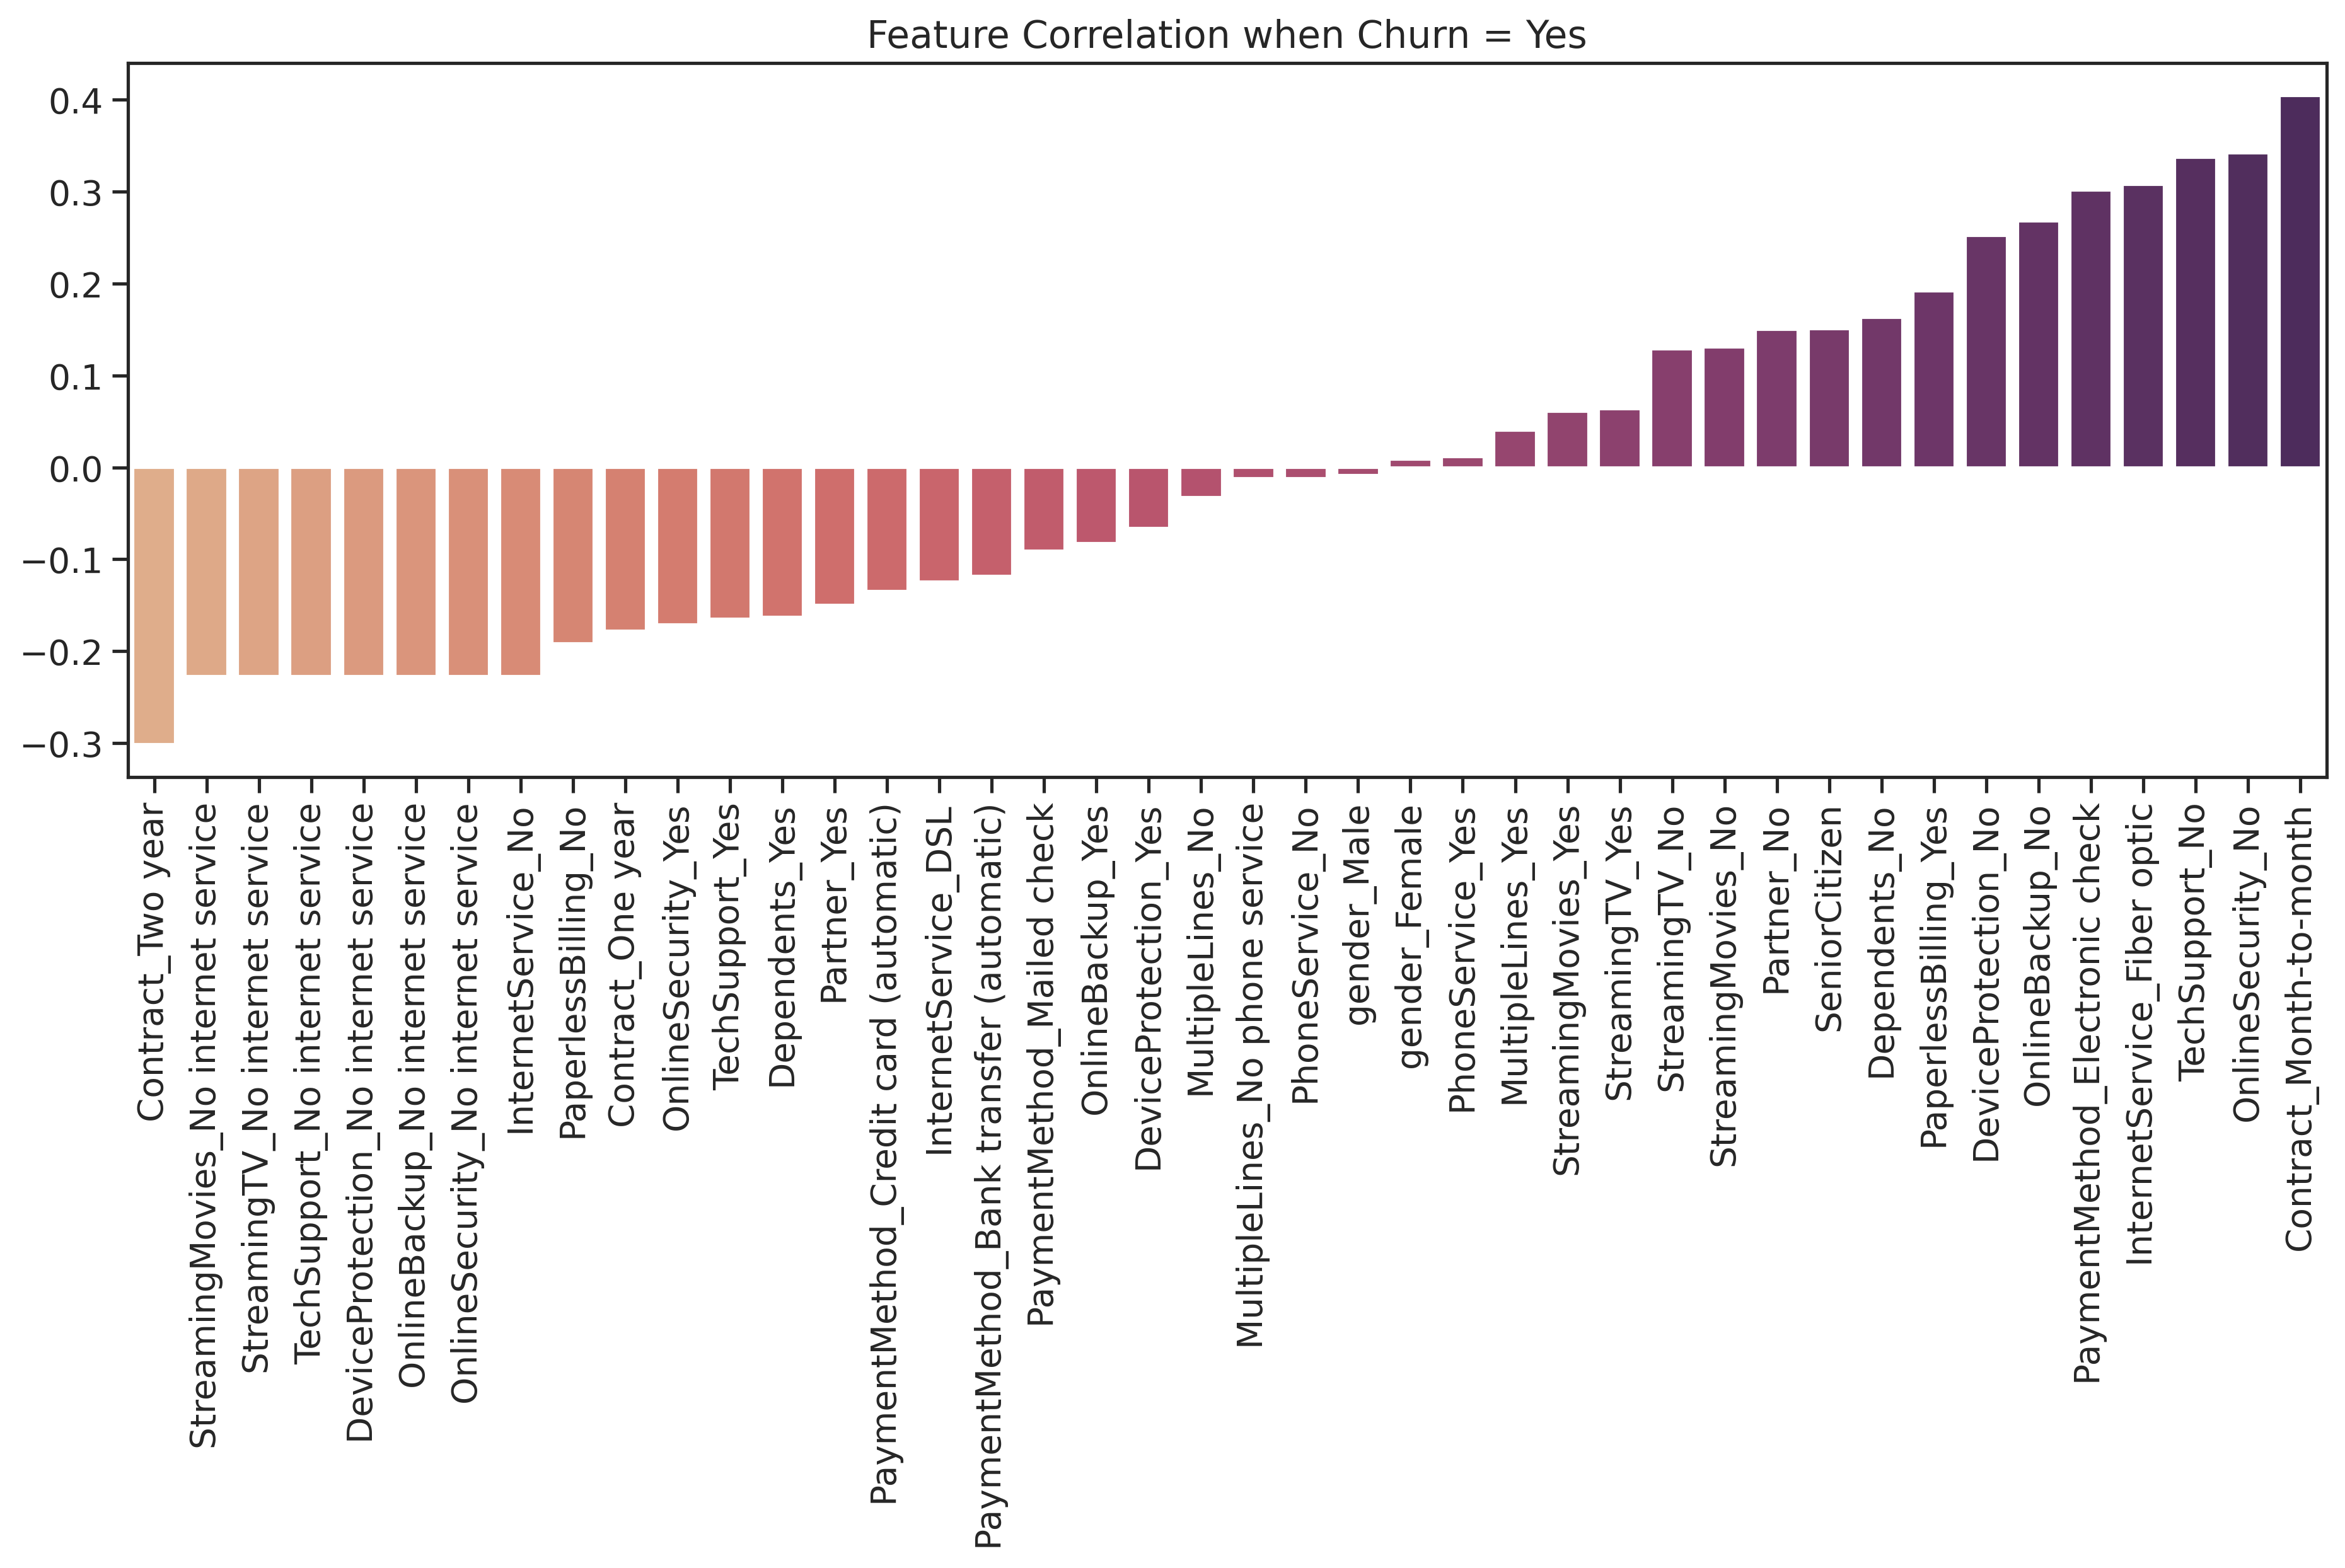

In [101]:
plt.figure(figsize=(15,5),dpi=300)
sn.barplot(x=df_corr['Churn_Yes'].sort_values().iloc[1:-1].index,y=df_corr['Churn_Yes'].sort_values().iloc[1:-1].values,palette='flare')
plt.title('Feature Correlation when Churn = Yes')
plt.xticks(rotation=90);

For those customers who churn data shows positive correlation (although moderate) with next features:  month-to-month contract, absence of online security and absence of tech support.

Data also shows (moderate) negative correlation with two-year type of contract, streaming movies - no internet service and streaming tv - no internet service. 


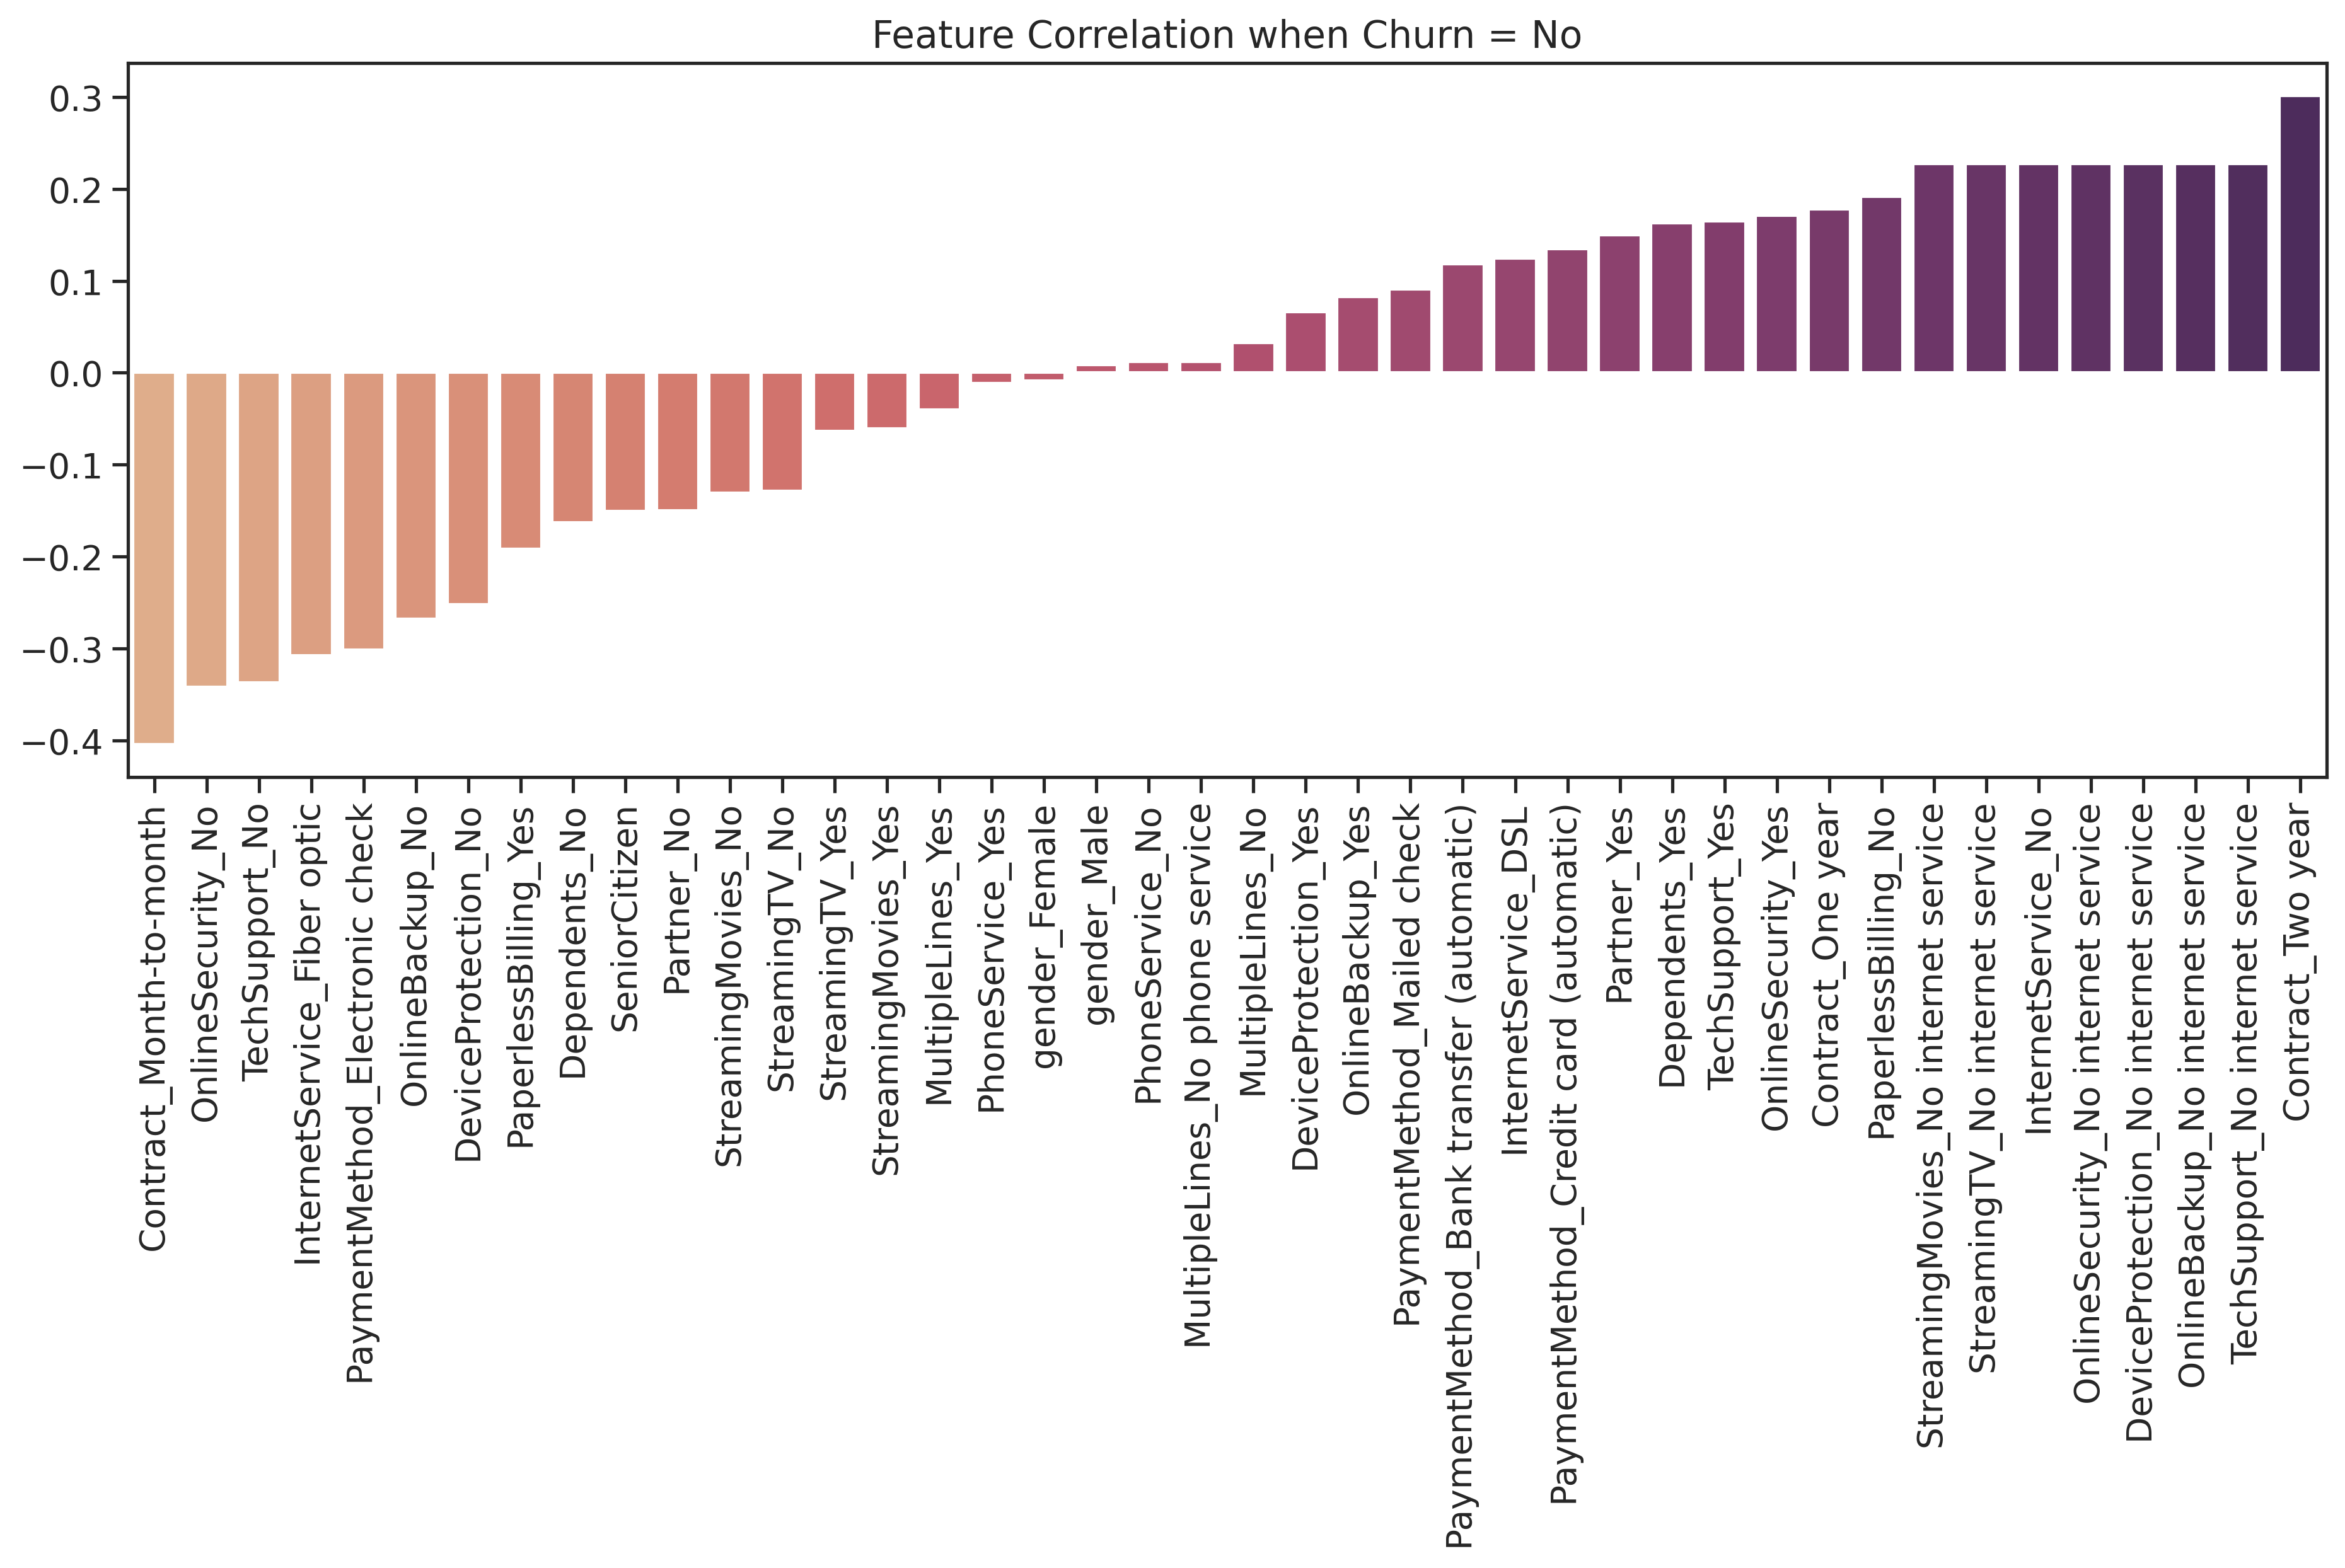

In [102]:
plt.figure(figsize=(15,5),dpi=300)
sn.barplot(x=df_corr['Churn_No'].sort_values().iloc[1:-1].index,y=df_corr['Churn_No'].sort_values().iloc[1:-1].values,palette='flare')
plt.title('Feature Correlation when Churn = No')
plt.xticks(rotation=90);

Data from customers who don't churn positively correlates with two-year type of contract and negatively with month-to-month contract.

## Data preparation

In [103]:
X = dataset.iloc[:, 1:-1].values
y = dataset.iloc[:, -1].values

In [104]:
X

array([['Female', 0, 'Yes', ..., 29.85, 29.85, 'No'],
       ['Male', 0, 'No', ..., 56.95, 1889.5, 'No'],
       ['Male', 0, 'No', ..., 53.85, 108.15, 'Yes'],
       ...,
       ['Female', 0, 'Yes', ..., 29.6, 346.45, 'No'],
       ['Male', 1, 'Yes', ..., 74.4, 306.6, 'Yes'],
       ['Male', 0, 'No', ..., 105.65, 6844.5, 'No']], dtype=object)

##Encoding categorical data


Independent variable X

In [105]:
dataset.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'yearly_tenure'], dtype=object)

In [106]:
X= pd.get_dummies(dataset.drop(['Churn','customerID', 'yearly_tenure'], axis=1), drop_first=True)

Dependent variable y

In [107]:
y= dataset['Churn']

In [108]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

##Splitting the dataset into the training set and the test set

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

##Feature scaling

In [110]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_to_scale = ['tenure','MonthlyCharges','TotalCharges']

X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.fit_transform(X_test[features_to_scale])

##Metrics for evaluating our models

In [111]:
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate(y_pred):
  cm = confusion_matrix(y_test, y_pred)
  print(cm)
  accuracy = accuracy_score(y_test, y_pred)
  precision = cm[1,1]/(cm[1,1] + cm[0,1]) # precision = true positives / (true positives + false positives)
  recall = cm[1,1] / (cm[1,1] + cm[1,0]) # recall = true positives / (true positives + false negatives)
  print("Accuracy: {:.2f} %".format(accuracy*100))
  print("Precision: {:.2f} %".format(precision*100))
  print("Recall: {:.2f} %".format(recall*100))

#Logistic Regression

In [112]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [113]:
y_pred = classifier.predict(X_test)
evaluate(y_pred)

[[919 122]
 [161 205]]
Accuracy: 79.89 %
Precision: 62.69 %
Recall: 56.01 %


#Decision Tree

In [114]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [115]:
y_pred = classifier.predict(X_test)
evaluate(y_pred)

[[811 230]
 [171 195]]
Accuracy: 71.50 %
Precision: 45.88 %
Recall: 53.28 %


#Random Forest

In [116]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [117]:
y_pred = classifier.predict(X_test)
evaluate(y_pred)

[[934 107]
 [197 169]]
Accuracy: 78.39 %
Precision: 61.23 %
Recall: 46.17 %


#XGBoost

In [118]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier()

In [119]:
y_pred = classifier.predict(X_test)
evaluate(y_pred)

[[932 109]
 [164 202]]
Accuracy: 80.60 %
Precision: 64.95 %
Recall: 55.19 %


In [120]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 80.41 %
Standard Deviation: 1.09 %


XGBoost algorithm performed the best on this customer churning data (maybe it could be even better by tuning hyperparameters, but oh well)